# 🪨 Stone

## 📥 라이브러리 준비

In [1]:
import numpy as np
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms, models
from PIL import Image
import matplotlib.pyplot as plt

# Thanks to **dhaitz**!
plt.style.use('https://github.com/dhaitz/matplotlib-stylesheets/raw/master/pitayasmoothie-dark.mplstyle')

# 한글폰트 설정
import matplotlib as mpl
mpl.rc('font', family='D2Coding')
mpl.rcParams['axes.unicode_minus'] = False

## 🗂️ 데이터셋 준비

### 🤔 데이터셋을 준비하는 방법

In [2]:
# 이미지 데이터가 있는 디렉토리와 데이터 세트 분할 비율(train_ratio)을 정한다.
dataset_dir = 'dataset'
train_ratio = 0.8   # 전체 데이터 중 훈련 데이터의 비중이 0.8이라는 의미이다.

#### 🧶 데이터 변환 정의

In [3]:
# 이미지 데이터를 ResNet50에서 다룰 수 있도록 변환시키는 방법을 정한다. (transform)
transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.Resize(224),
    transforms.ToTensor()
])
# convert image size to 224x224 for ResNet50 after crop

# 설정한 이미지 데이터 변환 방법을 출력하여 확인한다.
transform

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)

#### 📂 데이터 불러오기

In [4]:
# datasets.ImageFolder를 사용해서 학습 데이터(stone_dataset)를 만든다.
# 이전에 정의한 데이터 변환이 적용된다. 
dataset = datasets.ImageFolder(dataset_dir, transform=transform)

# 데이터의 형식을 확인한다.
dataset

Dataset ImageFolder
    Number of datapoints: 155
    Root location: dataset
    StandardTransform
Transform: Compose(
               RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               Resize(size=224, interpolation=bilinear, max_size=None, antialias=True)
               ToTensor()
           )

#### 🎰 인덱스 셔플

In [5]:
# train_data 사이즈만큼의 정수값을 갖는 인덱스 리스트(indices)를 만들고 확인한다.
dataset_size = len(dataset)
indices = np.arange(dataset_size)
display(indices)

# 인덱스 리스트를 랜덤하게 섞고 확인한다.
np.random.shuffle(indices)
indices

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154])

array([ 43,  99,  92,  82,  44, 139, 145, 151, 132,  14,  66,  83, 141,
         2,  80,   3, 124,  50, 127, 148,  41,  75,  19,  29, 100,  36,
        78, 110, 138,  96, 118, 126, 146,  71,  32, 131,   6, 149,  90,
       125,  27,  39, 104,  67, 116, 150,  85, 152, 105, 136, 143,  42,
        18,  68,   4,  57, 129,  46,   7, 130,  77,  61,  10,   8,  60,
        22, 122, 134,  97,  35, 103, 140,   0,  51, 115, 111,  37,  64,
        65,  70,  81,  40,  91,  98,  34,  87,  72,  28, 107,  13,  20,
         1,  38,  62,  73,  30, 112,  23, 119, 102,  52,  11,  54, 120,
        55,  25, 128, 101, 147,  53,  63,  49, 154, 142,  74, 137,  59,
       135,  56,  58,  16,  89,  26,  21, 114,  17,  84,  94, 108,  48,
        93,  76,   9,  88, 133,  79, 106,  31, 117,  69,   5,  24,  12,
        15, 121, 144, 113,  47,  95,  45, 109, 123, 153,  33,  86])

#### ✂️ 인덱스 분할

In [6]:
# 분할 비율(train_size)에 해당하는 인덱스를 계산하고 확인해 본다.
train_size = int(dataset_size * train_ratio)
test_size = dataset_size - train_size
print(f'{train_size=} {test_size=}')

# 학습 데이터 인덱스 리스트 및 테스트 인덱스 리스트를 만들고 확인해 본다.
train_indices, test_indices = indices[:train_size], indices[train_size:]
train_indices, test_indices

train_size=124 test_size=31


(array([ 43,  99,  92,  82,  44, 139, 145, 151, 132,  14,  66,  83, 141,
          2,  80,   3, 124,  50, 127, 148,  41,  75,  19,  29, 100,  36,
         78, 110, 138,  96, 118, 126, 146,  71,  32, 131,   6, 149,  90,
        125,  27,  39, 104,  67, 116, 150,  85, 152, 105, 136, 143,  42,
         18,  68,   4,  57, 129,  46,   7, 130,  77,  61,  10,   8,  60,
         22, 122, 134,  97,  35, 103, 140,   0,  51, 115, 111,  37,  64,
         65,  70,  81,  40,  91,  98,  34,  87,  72,  28, 107,  13,  20,
          1,  38,  62,  73,  30, 112,  23, 119, 102,  52,  11,  54, 120,
         55,  25, 128, 101, 147,  53,  63,  49, 154, 142,  74, 137,  59,
        135,  56,  58,  16,  89,  26,  21]),
 array([114,  17,  84,  94, 108,  48,  93,  76,   9,  88, 133,  79, 106,
         31, 117,  69,   5,  24,  12,  15, 121, 144, 113,  47,  95,  45,
        109, 123, 153,  33,  86]))

#### ♒ 데이터 샘플러와 데이터 로더 정의

In [7]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

# 데이터 샘플링 방식(SubsetRandomSampler)을 지정한다.
train_sampler = SubsetRandomSampler(train_indices)
test_sampler = SubsetRandomSampler(test_indices)

# 데이터 로더를 만든다. (sampler, 배치 크기를 지정할 수 있음)
train_loader = DataLoader(dataset, sampler=train_sampler, batch_size=16)
test_loader = DataLoader(dataset, sampler=test_sampler, batch_size=16)

#### 📦 하나의 함수로 정리

In [8]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

# 위의 코드들을 묶어서 load_split_train_test() 함수를 만든다. (입력 : 데이터 디렉토리, 분할 비율) (출력 : 학습 데이터 로더, 테스트 데이터 로더)
def load_split_train_test(dataset_dir: str, train_ratio: float):
    transform = transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.Resize(224),
        transforms.ToTensor()
    ])
    
    dataset = datasets.ImageFolder(dataset_dir, transform=transform)

    dataset_size = len(dataset)
    indices = np.arange(dataset_size)
    np.random.shuffle(indices)

    train_size = int(dataset_size * train_ratio)
    train_indices, test_indices = indices[:train_size], indices[train_size:]
    
    train_sampler = SubsetRandomSampler(train_indices)
    test_sampler = SubsetRandomSampler(test_indices)

    train_loader = DataLoader(dataset, sampler=train_sampler, batch_size=16)
    test_loader = DataLoader(dataset, sampler=test_sampler, batch_size=16)
    
    return train_loader, test_loader

### 📚 데이터 로더 생성

In [9]:
dataset_dir = 'dataset'
train_ratio = 0.8

train_loader, test_loader = load_split_train_test(dataset_dir, train_ratio)

## 🔍 데이터셋 살펴보기

In [10]:
def get_random_images(num):
    """데이터셋에서 데이터를 임의로 선택해 반환한다."""
    
    dataset = datasets.ImageFolder(dataset_dir, transform=transform)
    indices = np.arange(len(dataset))
    np.random.shuffle(indices)
    indices = indices[:num]
    
    sampler = SubsetRandomSampler(indices)
    loader = DataLoader(dataset, sampler=sampler, batch_size=num)
    
    data_iter = iter(loader)
    images, labels = next(data_iter)
    
    return images, labels

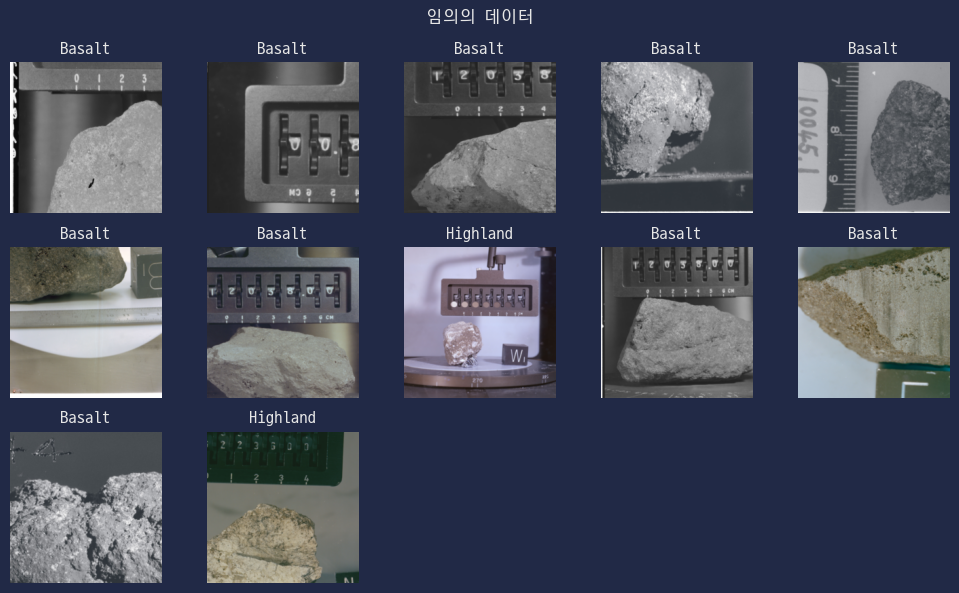

In [100]:
# 데이터셋에서 데이터를 뽑아서 시각화한다.
image_num = 12

classes = dataset.classes
images, labels = get_random_images(image_num)
to_pil = transforms.ToPILImage()

max_col = min(image_num, 5)
max_row = image_num // 5 + 1

plt.figure(figsize=(2 * max_col, 2 * max_row))
for i in range(image_num):
    image = to_pil(images[i])
    label = labels[i].item()
    
    plt.subplot(max_row, max_col, i + 1)
    plt.title(classes[label])
    plt.axis('off')
    plt.imshow(image)

plt.suptitle('임의의 데이터')
plt.tight_layout()
plt.show()

## 🧵 ResNet-50 모델 준비

In [12]:
# compute device를 정하고 확인한다.
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [13]:
# 사전학습된 모델을 불러온다.
model = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [14]:
for param in model.parameters():
    # 모델의 기존 가중치가 갱신되지 않게 고정한다.
    param.requires_grad = False

# 출력층을 변경한다.
model.fc = nn.Sequential(
    nn.Linear(2048, 512),
    nn.ReLU(),
    nn.Dropout(0.35),
    nn.Linear(512, 2),
    nn.LogSoftmax(dim=1)
)
# 모델을 cpu (또는 gpu)에 업로드한다. (cpu 업로드는 사실상 안 하는거나 다름 없음)
model.to(device)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 🔄️ 모델 훈련

In [15]:
criterion = nn.NLLLoss()
optimizer = optim.Adam(model.fc.parameters(), lr=0.01)
epochs = 10

print_every = 2

steps = 0
running_loss = 0
train_losses, test_losses = [], []

for epoch in range(epochs):
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        """저장된 기울기 값을 초기화해줍니다."""
        optimizer.zero_grad()
        
        """순전파를 수행하고 손실을 계산합니다."""
        logps = model.forward(inputs)
        loss = criterion(logps, labels)
        
        """역전파를 수행해 가중치를 갱신합니다."""
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        steps += 1
        print(f'Training step: {steps}', end='\r')
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            
            model.eval() # 평가 모드로 전환    
            with torch.no_grad():
                # 모든 테스트 데이터에 대해...
                for inputs, labels, in test_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    # 순전파 (예측)
                    logps = model.forward(inputs)
                    
                    # 정확도 계산
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()
                    
                    # 손실 계산
                    batch_loss = criterion(logps, labels)
                    test_loss += batch_loss.item()
            model.train() # 학습 모드로 전환
            
            train_loss = running_loss/len(train_loader)
            test_loss = test_loss / len(test_loader)
            train_losses.append(train_loss)
            test_losses.append(test_loss)
            
            accuracy = accuracy / len(test_loader)
            
            print(
                f'Step {steps}:\t'
                f'Epoch {epoch + 1}/{epochs}:\t'
                f'Train loss: {train_loss:.4f}\t'
                f'Test loss: {test_loss:.4f}\t'
                f'Test accuracy: {accuracy:.4f}'
            )
            
            running_loss = 0

Step 2:	Epoch 1/10:	Train loss: 0.1474	Test loss: 2.4319	Test accuracy: 0.5792
Step 4:	Epoch 1/10:	Train loss: 0.9303	Test loss: 0.3979	Test accuracy: 0.8063
Step 6:	Epoch 1/10:	Train loss: 0.2051	Test loss: 5.2859	Test accuracy: 0.5771
Step 8:	Epoch 1/10:	Train loss: 0.7657	Test loss: 0.2253	Test accuracy: 0.9021
Step 10:	Epoch 2/10:	Train loss: 0.3056	Test loss: 1.5119	Test accuracy: 0.6771
Step 12:	Epoch 2/10:	Train loss: 0.2990	Test loss: 0.3003	Test accuracy: 0.8708
Step 14:	Epoch 2/10:	Train loss: 0.1115	Test loss: 0.6406	Test accuracy: 0.8042
Step 16:	Epoch 2/10:	Train loss: 0.0920	Test loss: 1.1524	Test accuracy: 0.7083
Step 18:	Epoch 3/10:	Train loss: 0.1717	Test loss: 0.5802	Test accuracy: 0.8729
Step 20:	Epoch 3/10:	Train loss: 0.1534	Test loss: 0.2329	Test accuracy: 0.9042
Step 22:	Epoch 3/10:	Train loss: 0.0518	Test loss: 0.2639	Test accuracy: 0.9021
Step 24:	Epoch 3/10:	Train loss: 0.1311	Test loss: 0.4642	Test accuracy: 0.8042
Step 26:	Epoch 4/10:	Train loss: 0.0501	Test

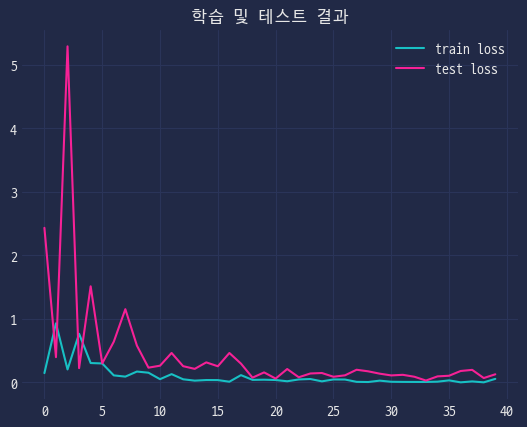

In [16]:
# 시각화
plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')
plt.legend()
plt.title('학습 및 테스트 결과')
plt.show()

## 💾 학습된 모델 저장하고 불러오기

In [17]:
# 추후 로드하여 사용할 수 있도록 학습/테스트 완료된 모델을 저장한다.
torch.save(model, 'checkpoints/stone.pth')

In [20]:
# 저장한 모델을 불러온다.
model = torch.load('checkpoints/stone.pth', weights_only=False)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

## 🏷️ 실제로 분류해보기

In [96]:
def predict(image):
    image_tensor = transform(image).float()
    input_ = image_tensor.unsqueeze_(0)
    input_ = input_.to(device)
    output = model(input_)
    index = output.data.numpy().argmax()
    return index

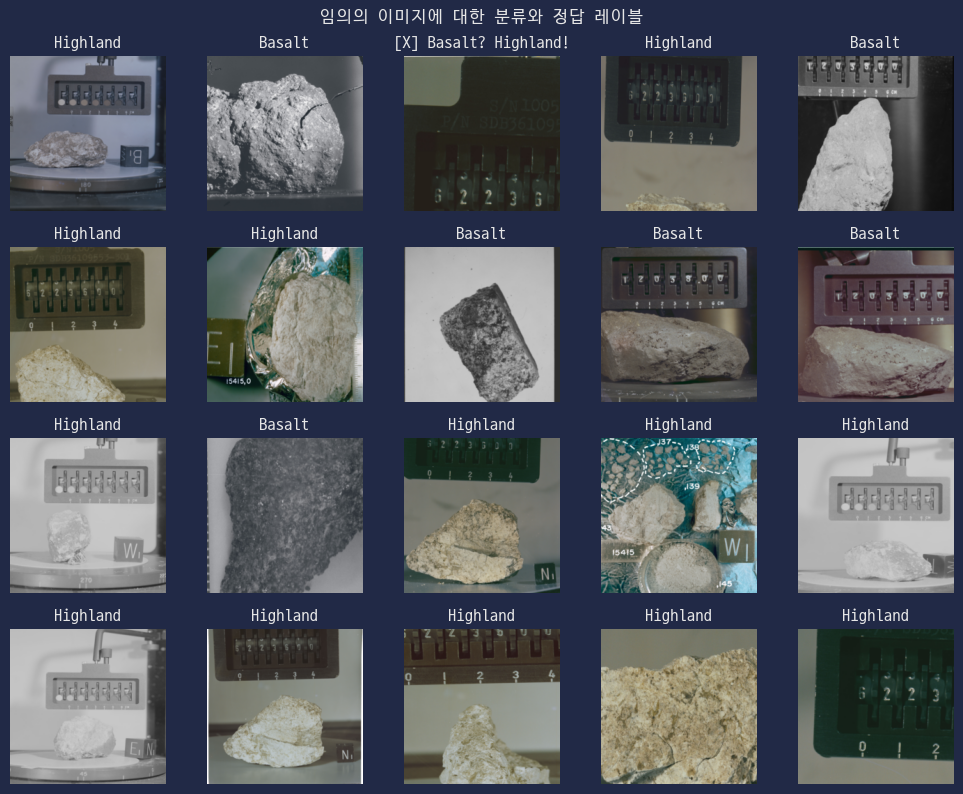

In [98]:
model.eval()

image_num = 20

classes = dataset.classes
images, labels = get_random_images(image_num)
to_pil = transforms.ToPILImage()

max_col = min(image_num, 5)
max_row = image_num // 5 + 1

plt.figure(figsize=(2 * max_col, 2 * max_row))
for i in range(image_num):
    image = to_pil(images[i])
    
    pred = classes[predict(image)]
    label = classes[labels[i].item()]
    
    plt.subplot(max_row, max_col, i + 1)
    if pred == label:
        plt.title(label)
    else:
        plt.title(f'[X] {pred}? {label}!')
    plt.axis('off')
    plt.imshow(image)

plt.suptitle('임의의 이미지에 대한 분류와 정답 레이블')
plt.tight_layout()
plt.show()